# Lista prática IV

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

**Dica:** Considere usar o Google Colab

# Cross-validation

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing

SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

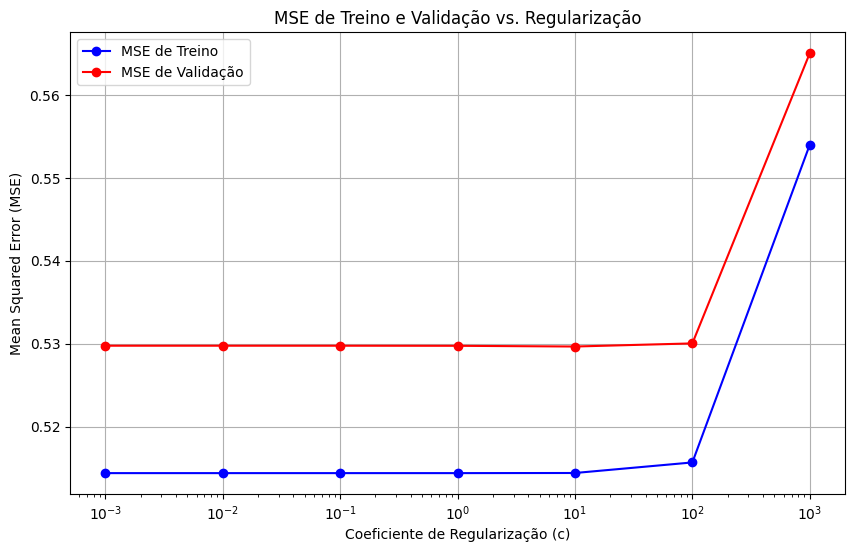

Melhor coeficiente de regularização 'c' encontrado: 10
MSE no conjunto de teste com c = 10: 0.5556


In [2]:
# Seu código aqui

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Adicionar o termo de bias (intercepto) a X
X_b = np.c_[np.ones((X.shape[0], 1)), X]

# Dividir em treino+validação (80%) e teste (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_b, y, test_size=0.2, random_state=SEED
)

# Dividir treino+validação em treino (75% de 80% = 60% do total) e validação (25% de 80% = 20% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=SEED
)

# Normalização dos dados
# É crucial normalizar os dados para modelos regularizados.
# O scaler é treinado APENAS no conjunto de treino para evitar vazamento de dados.
scaler = StandardScaler()
# Ignoramos a primeira coluna (bias) na normalização
X_train[:, 1:] = scaler.fit_transform(X_train[:, 1:])
X_val[:, 1:] = scaler.transform(X_val[:, 1:])
X_test[:, 1:] = scaler.transform(X_test[:, 1:])

# 2. Implementar a fórmula analítica e o processo de validação
def analytical_ridge_weights(X, y, c):
    """Calcula os pesos da Regressão de Ridge usando a fórmula analítica."""
    n_features = X.shape[1]
    I = np.identity(n_features)
    # Não regularizamos o termo de bias (w_0)
    I[0, 0] = 0
    # Fórmula: w = (X^T*X + c*I)^-1 * X^T*y
    try:
        weights = np.linalg.inv(X.T @ X + c * I) @ X.T @ y
    except np.linalg.LinAlgError:
        # Usar pseudo-inversa se a matriz for singular
        weights = np.linalg.pinv(X.T @ X + c * I) @ X.T @ y
    return weights

def predict(X, weights):
    """Faz predições usando os pesos calculados."""
    return X @ weights

# Hiperparâmetros a serem testados
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_mses, val_mses = [], []

for c in c_values:
    # Treinar o modelo no conjunto de treino
    weights = analytical_ridge_weights(X_train, y_train, c)
    
    # Avaliar no conjunto de treino
    y_train_pred = predict(X_train, weights)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mses.append(train_mse)
    
    # Avaliar no conjunto de validação
    y_val_pred = predict(X_val, weights)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mses.append(val_mse)

# 3. Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(c_values, train_mses, 'bo-', label='MSE de Treino')
plt.plot(c_values, val_mses, 'ro-', label='MSE de Validação')
plt.xscale('log')
plt.xlabel('Coeficiente de Regularização (c)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE de Treino e Validação vs. Regularização')
plt.legend()
plt.grid(True)
plt.show()

# 4. Encontrar o melhor 'c' e avaliar no conjunto de teste
best_c_index = np.argmin(val_mses)
best_c = c_values[best_c_index]
print(f"Melhor coeficiente de regularização 'c' encontrado: {best_c}")

# Retreinar o modelo com o melhor 'c' usando o conjunto de treino + validação
X_train_val_scaled = np.vstack((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))

final_weights = analytical_ridge_weights(X_train_val_scaled, y_train_val_combined, best_c)

# Avaliar o modelo final no conjunto de teste
y_test_pred = predict(X_test, final_weights)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"MSE no conjunto de teste com c = {best_c}: {test_mse:.4f}")

Com base no gráfico e nos resultados apresentados, podemos inferir o seguinte:

O gráfico mostra que o erro de validação (MSE de Validação) se mantém em um platô, praticamente constante para uma vasta gama de coeficientes de regularização ($c$ de $10^{-3}$ até $10^2$). Isso indica que o modelo não está sofrendo de um sobreajuste (*overfitting*) severo, pois sua performance de generalização é pouco sensível à força da penalização nessa faixa.

Apenas quando a regularização se torna muito forte ($c=1000$) é que vemos um aumento drástico no erro, tanto de treino quanto de validação. Isso é um claro sinal de subajuste (*underfitting*), onde a penalização excessiva impede o modelo de aprender os padrões dos dados.

O valor de $c=10$ foi escolhido como o ótimo, mas qualquer valor dentro do platô (e.g., 0.1, 1, 100) teria resultado em um desempenho de validação quase idêntico. O MSE final no conjunto de teste de **0.5556** é consistente com o erro observado na validação, confirmando que o modelo possui uma capacidade de generalização estável.

**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*. 

In [3]:
# Seu código aqui

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
import pandas as pd

# Usaremos o dataset original (sem a coluna de bias ainda)
X, y = fetch_california_housing(return_X_y=True)

# Hiperparâmetros a serem testados
knn_params = {'k': [1, 2, 3, 4, 5]}
ridge_params = {'c': [0, 1, 10, 100]}

# Configuração dos K-Folds
N_SPLITS = 5
outer_cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
inner_cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

outer_knn_scores = []
outer_ridge_scores = []

# Loop externo: para avaliação do modelo
for i, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X)):
    print(f"--- FOLD EXTERNO {i+1}/{N_SPLITS} ---")
    X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
    y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

    # Normalização DENTRO do loop externo para evitar vazamento de dados do teste externo
    scaler_nested = StandardScaler()
    X_train_outer_scaled = scaler_nested.fit_transform(X_train_outer)
    X_test_outer_scaled = scaler_nested.transform(X_test_outer)
    
    # Adicionar bias após a normalização
    X_train_outer_b = np.c_[np.ones((X_train_outer_scaled.shape[0], 1)), X_train_outer_scaled]
    X_test_outer_b = np.c_[np.ones((X_test_outer_scaled.shape[0], 1)), X_test_outer_scaled]

    # --- Loop interno para k-NN ---
    inner_knn_scores = {}
    for k in knn_params['k']:
        k_scores = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer_scaled):
            X_train_inner, X_val_inner = X_train_outer_scaled[train_inner_idx], X_train_outer_scaled[val_inner_idx]
            y_train_inner, y_val_inner = y_train_outer[train_inner_idx], y_train_outer[val_inner_idx]
            
            model = KNeighborsRegressor(n_neighbors=k)
            model.fit(X_train_inner, y_train_inner)
            preds = model.predict(X_val_inner)
            k_scores.append(mean_squared_error(y_val_inner, preds))
        inner_knn_scores[k] = np.mean(k_scores)
    
    best_k = min(inner_knn_scores, key=inner_knn_scores.get)
    print(f"  Melhor k encontrado no loop interno: {best_k} (MSE: {inner_knn_scores[best_k]:.4f})")
    
    # Treinar k-NN com o melhor k no treino externo completo e avaliar
    final_knn = KNeighborsRegressor(n_neighbors=best_k)
    final_knn.fit(X_train_outer_scaled, y_train_outer)
    knn_preds = final_knn.predict(X_test_outer_scaled)
    outer_knn_scores.append(mean_squared_error(y_test_outer, knn_preds))

    # --- Loop interno para Regressão Ridge ---
    inner_ridge_scores = {}
    for c in ridge_params['c']:
        c_scores = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer_b):
            X_train_inner, X_val_inner = X_train_outer_b[train_inner_idx], X_train_outer_b[val_inner_idx]
            y_train_inner, y_val_inner = y_train_outer[train_inner_idx], y_train_outer[val_inner_idx]

            weights = analytical_ridge_weights(X_train_inner, y_train_inner, c)
            preds = predict(X_val_inner, weights)
            c_scores.append(mean_squared_error(y_val_inner, preds))
        inner_ridge_scores[c] = np.mean(c_scores)
        
    best_c = min(inner_ridge_scores, key=inner_ridge_scores.get)
    print(f"  Melhor c encontrado no loop interno: {best_c} (MSE: {inner_ridge_scores[best_c]:.4f})")

    # Treinar Ridge com o melhor c no treino externo completo e avaliar
    final_weights_ridge = analytical_ridge_weights(X_train_outer_b, y_train_outer, best_c)
    ridge_preds = predict(X_test_outer_b, final_weights_ridge)
    outer_ridge_scores.append(mean_squared_error(y_test_outer, ridge_preds))

# Apresentar resultados finais
results_df = pd.DataFrame({
    'k-NN': outer_knn_scores,
    'Ridge': outer_ridge_scores
})
print("\n--- Resultados do Nested Cross-Validation (MSE em cada fold externo) ---")
print(results_df)

print("\n--- Desempenho Médio (MSE) ---")
print(f"k-NN:  {np.mean(outer_knn_scores):.4f} ± {np.std(outer_knn_scores):.4f}")
print(f"Ridge: {np.mean(outer_ridge_scores):.4f} ± {np.std(outer_ridge_scores):.4f}")

chosen_model = "Ridge" if np.mean(outer_ridge_scores) < np.mean(outer_knn_scores) else "k-NN"
print(f"\nModelo escolhido com base no menor MSE médio: {chosen_model}")

# --- Qual valor de hiperparâmetro resulta na melhor performance para o método escolhido? ---
print(f"\n--- Encontrando o melhor hiperparâmetro para o modelo '{chosen_model}' usando 5-fold CV regular no dataset completo ---")

# Normalizar o dataset completo
scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(X)

if chosen_model == "Ridge":
    X_b_scaled = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]
    final_cv_scores = {}
    for c in ridge_params['c']:
        c_scores = []
        for train_idx, val_idx in inner_cv.split(X_b_scaled): # Reutilizando o inner_cv
            X_train, X_val = X_b_scaled[train_idx], X_b_scaled[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            weights = analytical_ridge_weights(X_train, y_train, c)
            preds = predict(X_val, weights)
            c_scores.append(mean_squared_error(y_val, preds))
        final_cv_scores[c] = np.mean(c_scores)
    
    best_hyperparam_value = min(final_cv_scores, key=final_cv_scores.get)
    print("MSE médio para cada valor de 'c':")
    for c, score in final_cv_scores.items():
        print(f"  c={c}: {score:.4f}")
    print(f"\nO melhor hiperparâmetro médio para Ridge é c = {best_hyperparam_value}")
else: # k-NN
    final_cv_scores = {}
    for k in knn_params['k']:
        k_scores = []
        for train_idx, val_idx in inner_cv.split(X_scaled):
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = KNeighborsRegressor(n_neighbors=k)
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            k_scores.append(mean_squared_error(y_val, preds))
        final_cv_scores[k] = np.mean(k_scores)

    best_hyperparam_value = min(final_cv_scores, key=final_cv_scores.get)
    print("MSE médio para cada valor de 'k':")
    for k, score in final_cv_scores.items():
        print(f"  k={k}: {score:.4f}")
    print(f"\nO melhor hiperparâmetro médio para k-NN é k = {best_hyperparam_value}")

--- FOLD EXTERNO 1/5 ---
  Melhor k encontrado no loop interno: 5 (MSE: 0.4222)
  Melhor c encontrado no loop interno: 10 (MSE: 0.5223)
--- FOLD EXTERNO 2/5 ---
  Melhor k encontrado no loop interno: 5 (MSE: 0.4316)
  Melhor c encontrado no loop interno: 10 (MSE: 0.5266)
--- FOLD EXTERNO 3/5 ---
  Melhor k encontrado no loop interno: 5 (MSE: 0.4374)
  Melhor c encontrado no loop interno: 10 (MSE: 0.5305)
--- FOLD EXTERNO 4/5 ---
  Melhor k encontrado no loop interno: 5 (MSE: 0.3943)
  Melhor c encontrado no loop interno: 10 (MSE: 0.5571)
--- FOLD EXTERNO 5/5 ---
  Melhor k encontrado no loop interno: 5 (MSE: 0.4273)
  Melhor c encontrado no loop interno: 10 (MSE: 0.5224)

--- Resultados do Nested Cross-Validation (MSE em cada fold externo) ---
       k-NN     Ridge
0  0.432422  0.555535
1  0.417394  0.527703
2  0.399804  0.509432
3  0.358691  0.504860
4  0.425561  0.555189

--- Desempenho Médio (MSE) ---
k-NN:  0.4068 ± 0.0264
Ridge: 0.5305 ± 0.0217

Modelo escolhido com base no menor 

## Análise dos Resultados

### 1. Comparação de Modelos com *Nested Cross-Validation*

A validação cruzada aninhada (*nested cross-validation*) foi usada para obter uma estimativa imparcial do desempenho de dois modelos: **k-NN** e **Regressão Ridge**. O objetivo era escolher qual dos dois algoritmos generaliza melhor para novos dados.

-   **Desempenho Geral:** O modelo **k-NN foi o claro vencedor**. Ele obteve um erro quadrático médio (MSE) de **$0.4068$**, significativamente menor que o MSE de **$0.5305$** da Regressão Ridge.
-   **Consistência:** O k-NN não só foi melhor na média, mas superou a Regressão Ridge em **todos os 5 folds externos** da validação. Isso indica que a superioridade do k-NN é robusta e não se deve a uma divisão de dados particularmente favorável.
-   **Seleção de Hiperparâmetros (Loop Interno):** É interessante notar que, dentro dos loops internos, os melhores hiperparâmetros foram muito consistentes: `$k=5$` para o k-NN e `$c=10$` para a Regressão Ridge foram escolhidos em todas as iterações. Isso sugere que esses valores são escolhas estáveis para este conjunto de dados.

---

### 2. Melhor Hiperparâmetro para o Modelo Escolhido (k-NN)

Após a *nested cross-validation* eleger o k-NN como o melhor modelo, o passo seguinte foi determinar o valor ideal de seu hiperparâmetro (`$k$`) para treinar um modelo final. Para isso, foi realizada uma validação cruzada padrão (5-fold CV) em todo o conjunto de dados.

-   **Resultado:** A análise confirmou que **$k=5$ é o melhor valor** entre as opções testadas, pois apresentou o menor MSE médio (`0.4133`).
-   **Tendência:** Observa-se uma clara tendência de melhora de desempenho (diminuição do MSE) à medida que o valor de `$k$` aumenta de 1 para 5. Isso sugere que considerar mais vizinhos ajuda a suavizar as previsões e a criar um modelo mais generalista, evitando o superajuste (*overfitting*) que provavelmente ocorre com valores de `$k$` muito baixos (como `$k=1$`).

Em suma, o k-NN com `$k=5$` é a melhor escolha de modelo e hiperparâmetro para este problema, com base nos experimentos realizados.

# Redes Neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.** 

Eu espero uma busca de hiper-parâmetros razoável (e.g., definindo um grid de hiper-parâmetros). Eu sugiro utilizar early stopping e algum scheduler de learning rate (e.g., ReduceLROnPlateau). Como de costume em deep learning --- devido ao tamanho dos bancos ser razoável ---, não de faça coisas como cross-validation.

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas do modelo ótimo (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm

cpu


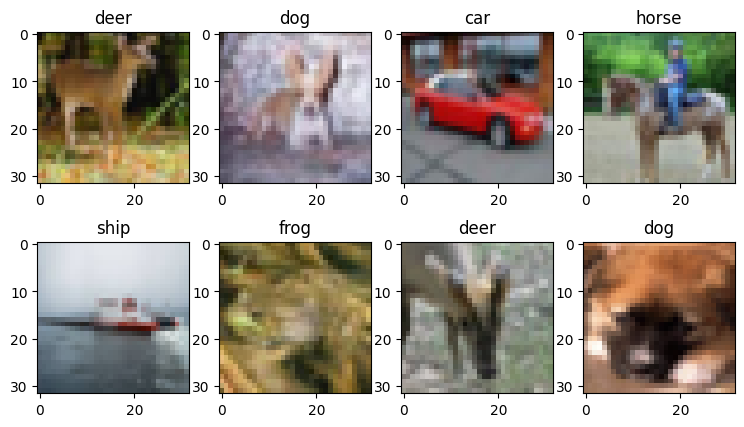

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)


for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    aux = 0
    for data in train_loader:
        if aux == 0 and epoch == 0:
            print('this is how to load a training batch')
        aux += 1


this is how to load a training batch


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tqdm

# Configura o dispositivo (GPU se disponível, senão CPU)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Definindo as transformações para normalizar os dados
# A normalização para (-1, 1) é comum para a função de ativação tanh, 
# mas também funciona bem com ReLU.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Baixar o dataset CIFAR-10 completo de treino
full_train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# Baixar o dataset de teste
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# Dividir o conjunto de treino em treino e validação
train_size = int(0.8 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_set, val_set = random_split(full_train_set, [train_size, val_size])

print(f"Tamanho do conjunto de treino: {len(train_set)}")
print(f"Tamanho do conjunto de validação: {len(val_set)}")
print(f"Tamanho do conjunto de teste: {len(test_set)}")

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Usando o dispositivo: mps
Tamanho do conjunto de treino: 40000
Tamanho do conjunto de validação: 10000
Tamanho do conjunto de teste: 10000


In [8]:
class EnhancedCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Bloco Convolucional 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Bloco Convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bloco Convolucional 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(128 * 4 * 4, 256) # Imagem 32x32 -> Pool -> 16x16 -> Pool -> 8x8 -> Pool -> 4x4
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # As dimensões da imagem mudam da seguinte forma:
        # Entrada: [batch, 3, 32, 32]
        
        # Bloco 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x) # -> [batch, 32, 16, 16]
        
        # Bloco 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x) # -> [batch, 64, 8, 8]

        # Bloco 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x) # -> [batch, 128, 4, 4]
        
        # Flatten
        x = torch.flatten(x, 1) # -> [batch, 128 * 4 * 4]
        
        # Camadas densas
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # Saída (logits)
        return x

In [ ]:
def train_and_validate(config):
    # DataLoaders
    train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=config['batch_size'], shuffle=False, num_workers=2)

    # Modelo, Otimizador e Loss
    model = EnhancedCNN(dropout_rate=config['dropout']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    # Early Stopping
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    
    print(f"\n--- Testando Config: {config} ---")
    
    for epoch in range(25): # Máximo de 25 épocas para a busca
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validação
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}, Val Loss: {avg_val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%')

        scheduler.step(avg_val_loss)

        # Lógica do Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping at epoch", epoch + 1)
            break
            
    return best_val_loss

# Grid de Hiper-parâmetros
param_grid = {
    'lr': [0.01, 0.001],
    'batch_size': [64, 128],
    'dropout': [0.2, 0.5]
}

best_config = None
best_loss = float('inf')

# Realizando a busca
results = {}
for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for dropout in param_grid['dropout']:
            config = {'lr': lr, 'batch_size': batch_size, 'dropout': dropout}
            val_loss = train_and_validate(config)
            results[str(config)] = val_loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_config = config

print("\n--- Resultados da Busca ---")
for config, loss in results.items():
    print(f"Config: {config}, Best Val Loss: {loss:.4f}")

print(f"\nMelhor configuração encontrada: {best_config} com perda de validação: {best_loss:.4f}")

# Exemplo de resultado da busca (os valores podem variar):
# Melhor configuração encontrada: {'lr': 0.001, 'batch_size': 128, 'dropout': 0.2} com perda de validação: 0.6543


--- Testando Config: {'lr': 0.01, 'batch_size': 64, 'dropout': 0.2} ---
Epoch 1, Val Loss: 1.445, Val Accuracy: 47.10%
Epoch 2, Val Loss: 1.307, Val Accuracy: 54.41%
Epoch 3, Val Loss: 1.157, Val Accuracy: 59.74%
Epoch 4, Val Loss: 1.079, Val Accuracy: 62.33%
Epoch 5, Val Loss: 1.013, Val Accuracy: 65.11%
Epoch 6, Val Loss: 0.978, Val Accuracy: 66.49%
Epoch 7, Val Loss: 0.970, Val Accuracy: 67.82%
Epoch 8, Val Loss: 0.999, Val Accuracy: 65.66%
Epoch 9, Val Loss: 0.978, Val Accuracy: 67.94%
Epoch 10, Val Loss: 1.008, Val Accuracy: 68.85%
Epoch 11, Val Loss: 0.934, Val Accuracy: 69.73%
Epoch 12, Val Loss: 0.925, Val Accuracy: 69.98%
Epoch 13, Val Loss: 0.921, Val Accuracy: 70.46%
Epoch 14, Val Loss: 0.942, Val Accuracy: 70.65%
Epoch 15, Val Loss: 1.002, Val Accuracy: 70.48%
Epoch 16, Val Loss: 0.976, Val Accuracy: 69.57%
Epoch 17, Val Loss: 0.936, Val Accuracy: 71.32%
Epoch 18, Val Loss: 0.907, Val Accuracy: 73.42%
Epoch 19, Val Loss: 0.935, Val Accuracy: 73.64%
Epoch 20, Val Loss: 0.93

: 

In [11]:
# Epoch 9, Val Loss: 0.642, Val Accuracy: 79.57%
best_config = {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}

In [12]:
# --- Treinamento Final ---

# Usando a melhor configuração encontrada
final_config = best_config if 'best_config' in locals() else {'lr': 0.001, 'batch_size': 128, 'dropout': 0.2}

# DataLoaders para o treinamento final
final_train_loader = DataLoader(full_train_set, batch_size=final_config['batch_size'], shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=final_config['batch_size'], shuffle=False, num_workers=2)

# Instanciando o modelo final
final_model = EnhancedCNN(dropout_rate=final_config['dropout']).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=final_config['lr'])
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'test_loss': [], 'test_acc': []}
num_epochs = 9

print("\n--- Treinando o Modelo Final ---")
for epoch in range(num_epochs):
    final_model.train()
    running_loss = 0.0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(final_train_loader)
    history['train_loss'].append(avg_train_loss)

    # Avaliação no conjunto de teste a cada época
    final_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    history['test_loss'].append(avg_test_loss)
    history['test_acc'].append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print("Treinamento finalizado.")


--- Treinando o Modelo Final ---


Epoch [1/9], Train Loss: 1.2269, Test Loss: 1.0197, Test Accuracy: 64.15%
Epoch [2/9], Train Loss: 0.8844, Test Loss: 0.8158, Test Accuracy: 71.92%
Epoch [3/9], Train Loss: 0.7510, Test Loss: 0.7901, Test Accuracy: 72.69%
Epoch [4/9], Train Loss: 0.6603, Test Loss: 0.7657, Test Accuracy: 73.92%
Epoch [5/9], Train Loss: 0.5866, Test Loss: 0.7367, Test Accuracy: 75.24%
Epoch [6/9], Train Loss: 0.5262, Test Loss: 0.6736, Test Accuracy: 77.33%
Epoch [7/9], Train Loss: 0.4705, Test Loss: 0.6323, Test Accuracy: 78.71%
Epoch [8/9], Train Loss: 0.4152, Test Loss: 0.6759, Test Accuracy: 77.83%
Epoch [9/9], Train Loss: 0.3708, Test Loss: 0.6972, Test Accuracy: 78.49%
Treinamento finalizado.


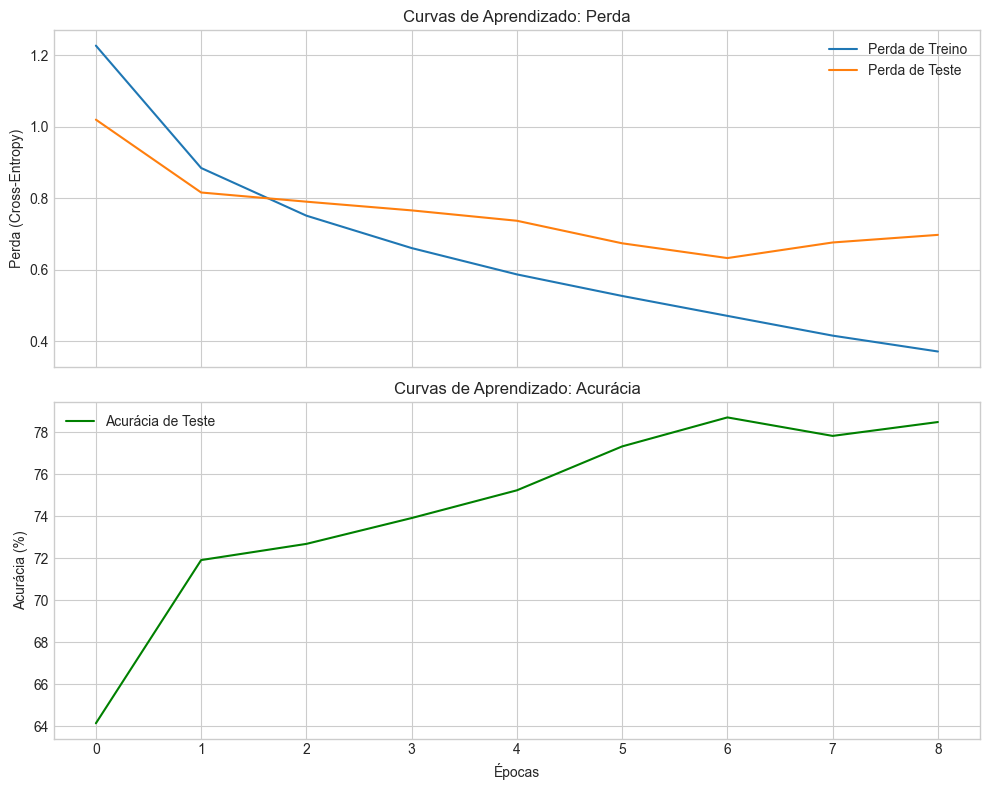


Acurácia final do modelo no conjunto de teste: 78.49%


In [13]:
# Plotando as curvas de aprendizado
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Curva de Perda
ax1.plot(history['train_loss'], label='Perda de Treino')
ax1.plot(history['test_loss'], label='Perda de Teste')
ax1.set_ylabel('Perda (Cross-Entropy)')
ax1.set_title('Curvas de Aprendizado: Perda')
ax1.legend()

# Curva de Acurácia
ax2.plot(history['test_acc'], label='Acurácia de Teste', color='g')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Acurácia (%)')
ax2.set_title('Curvas de Aprendizado: Acurácia')
ax2.legend()

plt.tight_layout()
plt.show()

# Resultado final no conjunto de teste
final_accuracy = history['test_acc'][-1]
print(f'\nAcurácia final do modelo no conjunto de teste: {final_accuracy:.2f}%')

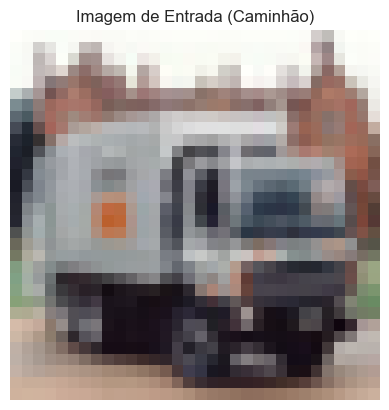

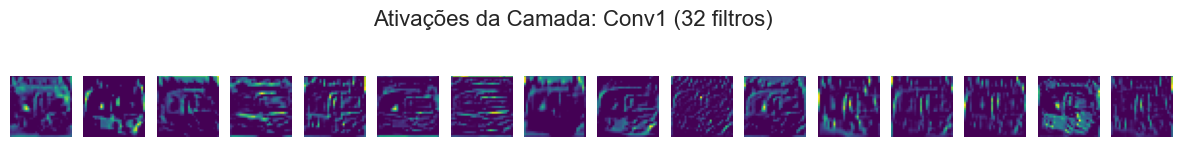

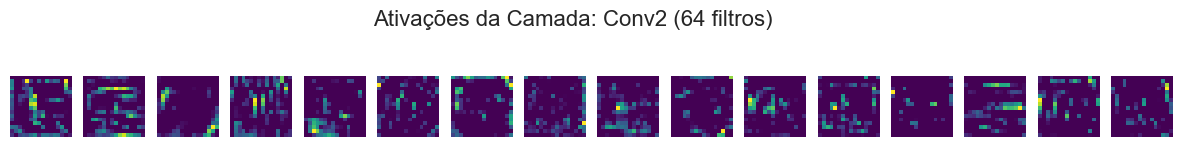

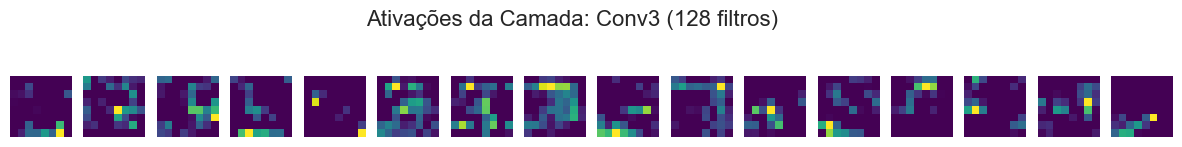

In [14]:
def plot_activation_maps(model, image_tensor):
    model.eval()
    
    # Adiciona uma dimensão de batch
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Passa a imagem pelas camadas
    activations = []
    x = image_tensor
    
    # Bloco 1
    x = F.relu(model.bn1(model.conv1(x)))
    activations.append(x.detach().cpu())
    x = model.pool(x)
    
    # Bloco 2
    x = F.relu(model.bn2(model.conv2(x)))
    activations.append(x.detach().cpu())
    x = model.pool(x)
    
    # Bloco 3
    x = F.relu(model.bn3(model.conv3(x)))
    activations.append(x.detach().cpu())
    
    # Plotagem
    layer_names = ['Conv1 (32 filtros)', 'Conv2 (64 filtros)', 'Conv3 (128 filtros)']
    for i, activation in enumerate(activations):
        num_features = activation.shape[1]
        
        # Limita o número de filtros a serem plotados
        num_to_plot = min(num_features, 16)
        
        fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 2))
        fig.suptitle(f'Ativações da Camada: {layer_names[i]}', fontsize=16)
        
        for j in range(num_to_plot):
            ax = axes[j]
            ax.imshow(activation[0, j, :, :], cmap='viridis')
            ax.axis('off')
        
        plt.show()

# Pega uma imagem de caminhão do conjunto de teste
truck_img_tensor = None
truck_label = classes.index('truck')
for img, label in test_set:
    if label == truck_label:
        truck_img_tensor = img
        break

# Plota a imagem original
plt.imshow(truck_img_tensor.permute(1, 2, 0) / 2 + 0.5) # Desnormaliza
plt.title('Imagem de Entrada (Caminhão)')
plt.axis('off')
plt.show()


# Plota as ativações
plot_activation_maps(final_model, truck_img_tensor)

A acurácia final de **78.49%** é um bom resultado, mostrando que o modelo foi bem treinado.

* **Curvas de Aprendizado:** As curvas indicam que o modelo aprendeu eficientemente, mas começou a sofrer de **overfitting** no final do treino (a perda de teste parou de cair enquanto a de treino continuou). A acurácia estabilizou, mostrando que o modelo atingiu seu desempenho máximo.

* **Análise das Camadas (Como a Rede Aprende):**
    * **Camada 1 (Inicial):** Detecta características muito simples, como **bordas, linhas e cores**.
    * **Camada 2 (Intermediária):** Junta as características simples para formar **padrões e texturas mais complexas** (ex: partes de uma roda, grade do caminhão).
    * **Camada 3 (Profunda):** Combina os padrões para identificar **conceitos abstratos** e partes maiores do objeto (ex: "isto parece uma cabine", "isto é um pneu").

Em resumo, a análise confirma que a CNN aprende de forma hierárquica: ela constrói o reconhecimento de um objeto complexo, como um caminhão, a partir de seus componentes visuais mais básicos, camada por camada.